In [1]:
import os
import sys

import numpy as np
import pandas as pd
from scipy.stats import spearmanr, mannwhitneyu

import pytorch_lightning as pl
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

pl.seed_everything(32)

sys.path.append("/data/danai/scripts/LIVI/")
from src.analysis._utils import find_trans_fSNPs

Seed set to 32
/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 32


In [2]:
adata = sc.read_h5ad("/data/danai/Data/OneK1K/LogNorm_counts_across_celltypes_DCRM_protein-coding_Azimuth_only-immune-cells_HVG-HEX-10K.h5ad")
adata

AnnData object with n_obs × n_vars = 1172790 × 14212
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'pool', 'individual', 'percent_mt', 'latent', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'cell_label', 'sex', 'age', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_MITO', 'log1p_total_counts_MITO', 'pct_counts_MITO', 'total_counts_RIBO', 'log1p_total_counts_RIBO', 'pct_counts_RIBO', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC', 'n_genes', 'Norm_factors', 'major_celltype', 'predicted_celltype_l0', 'predicted_celltype_l1', 'predicted_celltype_l2', 'original_celltype', 'new_predicted_celltype_l2', 'new_predicted_celltype_l0', 'new_predicted_celltype_l1'
    var: 'GeneSymbol', 'features', 'MITO', 'RIBO', 'ERCC', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'downregulated_NK', '

In [3]:
gene_anno = pd.read_csv("/data/danai/Data/OneK1K/OneK1K_HVG-HEX-10K_geneIDs_Biomart.txt", sep="\t", index_col=0)
gene_anno.rename(columns={"Gene stable ID":"feature_id", 
                         "Gene name":"gene_name",
                         "Chromosome/scaffold name":"gene_chromosome", 
                         "Gene start (bp)":"gene_start", 
                         "Gene end (bp)":"gene_end"},
                inplace=True)
gene_anno

,gene_start,gene_chromosome,gene_end,gene_name
Gene stable ID,,,,
ENSG00000000419,49551404,20,49575092,DPM1
ENSG00000000457,169818772,1,169863408,SCYL3
ENSG00000000460,169631245,1,169823221,C1orf112
ENSG00000000938,27938575,1,27961788,FGR
ENSG00000000971,196621008,1,196716634,CFH
...,...,...,...,...
ENSG00000273269,47293080,2,47403650,RP11-761B3.1
ENSG00000273274,32930670,1,32962287,ZBTB8B
ENSG00000273294,33987279,5,34124633,RP11-1084J3.4


In [4]:
adata.var.GeneSymbol = adata.var.GeneSymbol.str.strip()
adata.var = adata.var.merge(gene_anno.filter(["gene_chromosome", "gene_start", "gene_end"]), right_index=True, left_index=True)
adata.var = adata.var.assign(upstream_5MB = adata.var.apply(lambda x: max(0, x.gene_start - 5000000), axis=1),
                             downstream_5MB = adata.var.apply(lambda x: x.gene_end + 5000000, axis=1))

In [5]:
trans_eQTLGen_sign = pd.read_csv("/data/danai/Data/OneK1K/trans-eQTLGen-FDR005_OneK1K.tsv", sep="\t")
trans_eQTLGen_sign = trans_eQTLGen_sign.assign(snp_id = [i[0]+":"+i[1] for i in trans_eQTLGen_sign.SNP_id1.str.split("_")])
trans_eQTLGen_sign = trans_eQTLGen_sign.assign(QTL = trans_eQTLGen_sign.apply(lambda x: x.Gene+"-"+x.snp_id, axis=1))

In [6]:
results_dir = "/data/danai/Data/OneK1K/LIVI2_testing_results/"
model = "2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder_best"
model_results_dir = os.path.join(results_dir, model)
os.path.isdir(model_results_dir)

True

In [7]:
sc.settings.figdir = os.path.join(model_results_dir, "Figures")

In [8]:
GxC_effects = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_LMM_results_BH-0.05_Ucontext.tsv"),
    sep="\t"
)
GxC_effects.Factor = GxC_effects.Factor.str.replace("U_", "D_")
GxC_effects.SNP_id.nunique()

941

In [9]:
GxC_effects[["SNP_chrom", "SNP_pos"]] = GxC_effects.SNP_id.str.split(":", expand=True)

GxC_effects = GxC_effects.assign(fQTL = GxC_effects["SNP_id"]+"__"+GxC_effects["Factor"])

In [10]:
DxC_decoder = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_GxC_decoder.tsv"),
    sep="\t", index_col=0
)
DxC_decoder.columns = DxC_decoder.columns.str.replace("GxC", "DxC")
DxC_decoder.head()

,DxC_Factor1,DxC_Factor2,DxC_Factor3,DxC_Factor4,DxC_Factor5,DxC_Factor6,DxC_Factor7,DxC_Factor8,DxC_Factor9,DxC_Factor10,...,DxC_Factor691,DxC_Factor692,DxC_Factor693,DxC_Factor694,DxC_Factor695,DxC_Factor696,DxC_Factor697,DxC_Factor698,DxC_Factor699,DxC_Factor700
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000257019,0.000003,-0.000156,0.000261,-0.000105,0.000109,-0.000148,0.000145,0.000002,0.000106,-0.000083,...,-0.000125,-0.000088,0.000062,-0.000037,-0.000043,-0.000013,-0.000199,-0.000141,0.000042,0.000049
ENSG00000166987,-0.000101,-0.000302,0.000002,-0.000025,0.000096,-0.000122,0.000290,-0.000218,-0.000033,0.000128,...,-0.000093,-0.000059,-0.000712,0.000007,-0.000217,0.000056,0.000027,0.000117,-0.000141,0.000014
ENSG00000170624,-0.000007,-0.000096,-0.000228,0.000753,-0.000033,-0.000042,-0.000032,0.001457,0.000291,-0.000079,...,-0.000690,0.000181,-0.004836,0.000014,-0.000040,0.000021,0.000080,0.000070,-0.000669,-0.000014
ENSG00000140519,0.000013,-0.000071,0.000062,-0.000007,-0.000070,0.000082,-0.000036,0.000126,-0.000059,-0.000021,...,0.000164,0.000251,-0.000099,0.000035,-0.000080,-0.000019,-0.000139,0.000042,-0.000011,-0.000129
ENSG00000117115,-0.000463,-0.000236,0.000113,-0.000527,0.000036,0.000147,-0.000130,-0.000716,-0.000064,0.000002,...,0.000046,0.000210,0.000123,-0.000185,-0.000235,0.000060,-0.000145,0.000712,-0.000128,-0.000025


In [11]:
# tensorqtl_results = pd.read_csv("/data/danai/Data/OneK1K/Benchmarks/TensorQTL/All_celltypes_results_tensorQTL-benchmark_significant_Bonferroni-across-everything_005.tsv", sep="\t")
tensorqtl_results = pd.read_csv("/data/danai/Data/OneK1K/Benchmarks/TensorQTL/All_celltypes_results_tensorQTL_significant_BH_005.tsv", sep="\t")
tensorqtl_results.head()

,SNP_id,gene,p_value,effect_size,effect_size_se,ref_allele,alt_allele,celltype,Storey_q,BH_corrected_pvalue,BY_corrected_pvalue
0,1:3091587,ENSG00000129691,1.626467e-07,0.379141,0.071849,C,T,CD4-ET,0.016391,0.016391,0.357406
1,1:4193551,ENSG00000226209,2.383485e-08,0.137090,0.024354,G,A,CD4-ET,0.003805,0.003805,0.082976
2,1:4668670,ENSG00000184925,2.701358e-07,0.250460,0.048347,G,A,CD4-ET,0.023879,0.023879,0.520671
3,1:11171226,ENSG00000270800,2.312485e-08,0.116015,0.020590,C,T,CD4-ET,0.003718,0.003718,0.081068
4,1:11280994,ENSG00000270800,2.312485e-08,0.116015,0.020590,T,C,CD4-ET,0.003718,0.003718,0.081068


In [12]:
tensorqtl_results.celltype.nunique()

14

In [13]:
tensorqtl_results = tensorqtl_results.assign(eQTL = tensorqtl_results["SNP_id"]+"__"+tensorqtl_results["gene"])

In [14]:
tensorqtl_results[["SNP_chrom", "SNP_pos"]] = tensorqtl_results.SNP_id.str.split(":", expand=True)

In [15]:
effects_LIVI_not_tensor = GxC_effects.loc[~GxC_effects.SNP_id.isin(tensorqtl_results.SNP_id)]
print(effects_LIVI_not_tensor.shape)
effects_LIVI_not_tensor.SNP_id.nunique()

(2591, 10)


604

In [16]:
effects_LIVI_not_tensor.SNP_chrom = effects_LIVI_not_tensor.SNP_chrom.astype(int)
effects_LIVI_not_tensor.SNP_pos = effects_LIVI_not_tensor.SNP_pos.astype(int)

/tmp/ipykernel_1837430/4133486798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effects_LIVI_not_tensor.SNP_chrom = effects_LIVI_not_tensor.SNP_chrom.astype(int)
/tmp/ipykernel_1837430/4133486798.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effects_LIVI_not_tensor.SNP_pos = effects_LIVI_not_tensor.SNP_pos.astype(int)


In [23]:
trans_fSNPs = find_trans_fSNPs(DxC_effects=effects_LIVI_not_tensor, DxC_decoder=DxC_decoder, adata=adata)
trans_fSNPs

,SNP_id,Factor
0,18:8323984,D_Factor19
1,5:32694942,D_Factor21
2,10:99136403,D_Factor25
3,7:17442679,D_Factor39
4,6:10982973,D_Factor44
...,...,...
349,6:167406633,D_Factor683
350,7:100512119,D_Factor686
351,10:70982941,D_Factor690
352,17:49244747,D_Factor691


In [24]:
trans_fSNPs.SNP_id.nunique()

294

In [25]:
adata.var.rename(columns={"genesymbol":"GeneSymbol"}, inplace=True)

In [26]:
trans_fSNPs = trans_fSNPs.assign(fQTL = trans_fSNPs.SNP_id+"__"+trans_fSNPs.Factor)
trans_fSNPs = trans_fSNPs.merge(effects_LIVI_not_tensor.filter([c for c in effects_LIVI_not_tensor.columns if c not in ["SNP_id", "Factor"]]), on="fQTL", how="left")
trans_fSNPs

,SNP_id,Factor,fQTL,effect_size,effect_size_se,p_value,assessed_allele,corrected_pvalue,SNP_chrom,SNP_pos
0,18:8323984,D_Factor19,18:8323984__D_Factor19,0.242943,0.055565,1.114032e-05,A,0.021257,18,8323984
1,5:32694942,D_Factor21,5:32694942__D_Factor21,-0.273905,0.062873,1.198885e-05,C,0.022690,5,32694942
2,10:99136403,D_Factor25,10:99136403__D_Factor25,0.186891,0.042861,1.177085e-05,C,0.022316,10,99136403
3,7:17442679,D_Factor39,7:17442679__D_Factor39,0.176963,0.041870,2.176661e-05,A,0.037558,7,17442679
4,6:10982973,D_Factor44,6:10982973__D_Factor44,-0.224585,0.053523,2.497140e-05,T,0.042181,6,10982973
...,...,...,...,...,...,...,...,...,...,...
349,6:167406633,D_Factor683,6:167406633__D_Factor683,0.342276,0.076638,7.152663e-06,C,0.014407,6,167406633
350,7:100512119,D_Factor686,7:100512119__D_Factor686,-0.159172,0.037500,2.005796e-05,C,0.035081,7,100512119
351,10:70982941,D_Factor690,10:70982941__D_Factor690,0.339352,0.065385,1.730005e-07,T,0.000470,10,70982941
352,17:49244747,D_Factor691,17:49244747__D_Factor691,-0.280535,0.067103,2.675186e-05,G,0.044668,17,49244747


In [28]:
trans_fSNPs.to_csv(
    os.path.join(model_results_dir, "trans-fSNPs_only-LIVI.tsv"), sep="\t", index=False, header=True)

### N eGenes

/tmp/ipykernel_1837430/3698936957.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sns.kdeplot(trans_eQTLGen_sign.loc[trans_eQTLGen_sign.snp_id.isin(GxC_effects.SNP_id)].groupby("snp_id").apply(lambda x: x.Gene.nunique()),
/tmp/ipykernel_1837430/3698936957.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sns.kdeplot(trans_eQTLGen_sign.loc[trans_eQTLGen_sign.snp_id.isin(tensorqtl_results.SNP_id)].groupby("snp_id

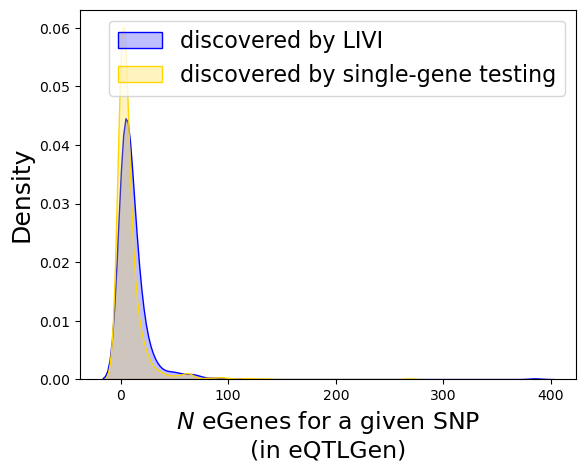

In [17]:
fig, axs = plt.subplots()
sns.kdeplot(trans_eQTLGen_sign.loc[trans_eQTLGen_sign.snp_id.isin(GxC_effects.SNP_id)].groupby("snp_id").apply(lambda x: x.Gene.nunique()), 
            color="blue", fill="blue", label="discovered by LIVI", ax=axs)
sns.kdeplot(trans_eQTLGen_sign.loc[trans_eQTLGen_sign.snp_id.isin(tensorqtl_results.SNP_id)].groupby("snp_id").apply(lambda x: x.Gene.nunique()), 
            color="gold", fill="gold", label="discovered by single-gene testing", ax = axs)
axs.set_xlabel("$N$ eGenes for a given SNP\n(in eQTLGen)", fontsize=17)
axs.set_ylabel("Density", fontsize=18)
# axs.set_ylim(0,200)
axs.legend(fontsize=16)
plt.savefig(os.path.join(model_results_dir, "Figures", "KDEplot_N_eGenes_LIVI_vs_tensorQTL.png"),
            transparent=True, bbox_inches="tight", dpi=300)
plt.savefig(os.path.join(model_results_dir, "Figures", "KDEplot_N_eGenes_LIVI_vs_tensorQTL.eps"),
            transparent=True, bbox_inches="tight", dpi=300)
plt.savefig(os.path.join(model_results_dir, "Figures", "KDEplot_N_eGenes_LIVI_vs_tensorQTL.pdf"),
            transparent=True, bbox_inches="tight", dpi=600)

/tmp/ipykernel_1356920/1311180318.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/tmp/ipykernel_1356920/1311180318.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


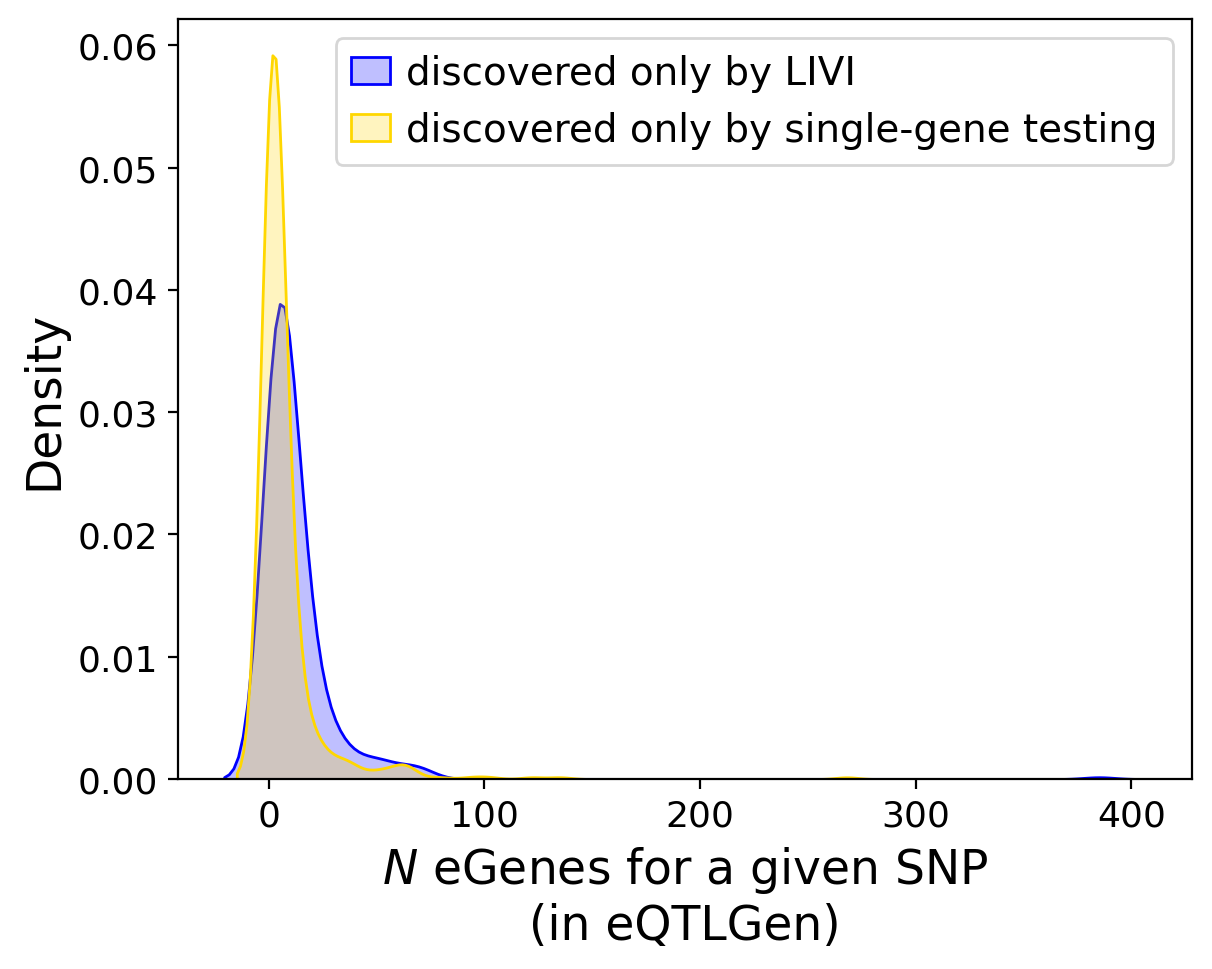

In [30]:
fig, axs = plt.subplots(figsize=(6.5,5))
sns.kdeplot(trans_eQTLGen_sign.loc[trans_eQTLGen_sign.snp_id.isin(effects_LIVI_not_tensor.SNP_id)].groupby("snp_id").apply(lambda x: x.Gene.nunique()), 
    color="blue", fill="blue", label="discovered only by LIVI", ax=axs)
sns.kdeplot(
    trans_eQTLGen_sign.loc[(trans_eQTLGen_sign.snp_id.isin(tensorqtl_results.SNP_id)) & (~trans_eQTLGen_sign.snp_id.isin(GxC_effects.SNP_id))
    ].groupby("snp_id").apply(lambda x: x.Gene.nunique()), 
            color="gold", fill="gold", label="discovered only by single-gene testing", ax=axs)
axs.set_xlabel("$N$ eGenes for a given SNP\n(in eQTLGen)", fontsize=17)
axs.set_ylabel("Density", fontsize=17)
axs.legend(fontsize=14, handlelength=1, loc="upper right")
axs.tick_params(axis="both", labelsize=13)
plt.savefig(os.path.join(model_results_dir, "Figures", "KDEplot_N_eGenes_only-LIVI_vs_only-tensorQTL.png"),
            transparent=True, bbox_inches="tight", dpi=300)
plt.savefig(os.path.join(model_results_dir, "Figures", "KDEplot_N_eGenes_only-LIVI_vs_only-tensorQTL.eps"),
            transparent=True, bbox_inches="tight", dpi=300)
plt.savefig(os.path.join(model_results_dir, "Figures", "KDEplot_N_eGenes_only-LIVI_vs_only-tensorQTL.pdf"),
            transparent=True, bbox_inches="tight", dpi=600)

In [20]:
n_genes_only_genelevel = trans_eQTLGen_sign.loc[
(trans_eQTLGen_sign.snp_id.isin(tensorqtl_results.SNP_id)) & (~trans_eQTLGen_sign.snp_id.isin(GxC_effects.SNP_id))
].groupby("SNP").apply(lambda x: x.Gene.nunique(), include_groups=False)

n_genes_only_livi = trans_eQTLGen_sign.loc[trans_eQTLGen_sign.snp_id.isin(effects_LIVI_not_tensor.SNP_id)
                      ].groupby("SNP").apply(lambda x: x.Gene.nunique(), include_groups=False)

mannwhitneyu(n_genes_only_livi, n_genes_only_genelevel, alternative="greater")

MannwhitneyuResult(statistic=139094.0, pvalue=7.73251998967627e-29)

In [21]:
only_gene_level_snps = trans_eQTLGen_sign.loc[
(trans_eQTLGen_sign.snp_id.isin(tensorqtl_results.SNP_id)) & (~trans_eQTLGen_sign.snp_id.isin(GxC_effects.SNP_id))
].snp_id.unique().tolist()
len(only_gene_level_snps)

530

In [23]:
n_genes_df = trans_eQTLGen_sign.groupby(by="snp_id", observed=True).apply(
    lambda x: x.Gene.nunique(), include_groups=False).rename("N_genes").reset_index()
n_genes_df = n_genes_df.assign(
    only_in = n_genes_df.apply(lambda x: "LIVI" if x.snp_id in effects_LIVI_not_tensor.SNP_id.tolist() else "gene-level" if x.snp_id in only_gene_level_snps else None, axis=1)
)
n_genes_df

,snp_id,N_genes,only_in
0,10:101278725,2,None
1,10:101282200,2,None
2,10:101283328,2,None
3,10:101283330,2,None
4,10:101284237,2,None
...,...,...,...
2576,9:93928416,4,None
2577,9:93949075,3,None
2578,9:96893945,1,gene-level
2579,9:99161512,5,None


In [24]:
n_genes_df = n_genes_df.loc[~n_genes_df.only_in.isna()]

/tmp/ipykernel_1836776/2406972328.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(labels=["only\n"+axs.xaxis.get_ticklabels()[0].get_text(),


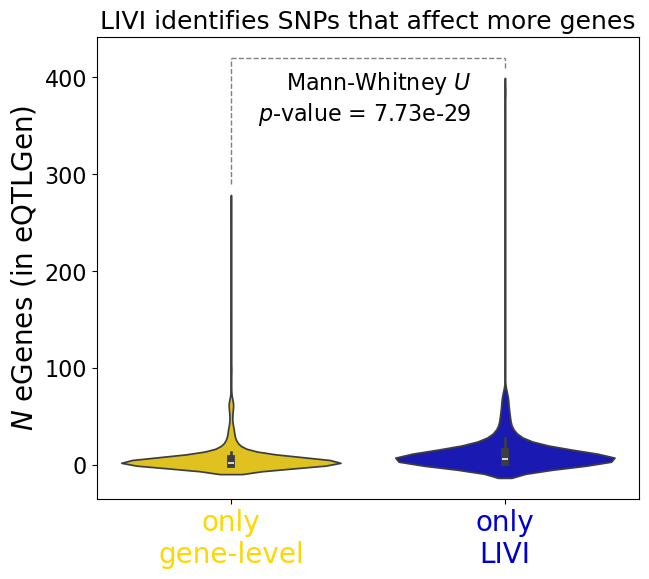

In [27]:
fig, axs = plt.subplots(ncols=1, constrained_layout=False, figsize=(7,6))

sns.violinplot(n_genes_df, y="N_genes", x="only_in", hue="only_in", 
               palette=["gold","mediumblue"], ax=axs, rasterized=True, legend=False)
axs.xaxis.get_ticklabels()[0].set_color("gold") 
axs.xaxis.get_ticklabels()[1].set_color("mediumblue")
axs.set_xticklabels(labels=["only\n"+axs.xaxis.get_ticklabels()[0].get_text(), 
                            "only\n"+axs.xaxis.get_ticklabels()[1].get_text()],
                    fontsize=20)
[t.set_fontsize(16) for t in axs.yaxis.get_ticklabels()] 
axs.set_ylabel("$N$ eGenes (in eQTLGen)", fontsize=20)
axs.set_xlabel("")
y_max = axs.get_ylim()[1]
axs.plot([axs.get_xticks()[0], axs.get_xticks()[1]], 
            [y_max, y_max], c="grey", linewidth=1, linestyle="--")
axs.plot([axs.get_xticks()[0], axs.get_xticks()[0]], 
            [y_max-130, y_max], c="grey", linewidth=1, linestyle="--")
axs.plot([axs.get_xticks()[1], axs.get_xticks()[1]], 
            [y_max-10, y_max], c="grey", linewidth=1, linestyle="--")
pval = mannwhitneyu(n_genes_only_livi, n_genes_only_genelevel, alternative="greater")[1]
axs.text(axs.get_xticks()[0]+0.1, y_max-65, f"Mann-Whitney $U$\n$p$-value = {pval:.2e}",
                        fontdict={"color":"black", "fontsize":16, "ma":"right"})
axs.set_title("LIVI identifies SNPs that affect more genes", fontdict={"fontsize":18})

plt.savefig(os.path.join(model_results_dir, "Figures", "Violin-plots_N-eGenes_only-LIVI_vs_only-gene-level.eps"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Violin-plots_N-eGenes_only-LIVI_vs_only-gene-level.png"),
            transparent=True, dpi=400, bbox_inches="tight")

/tmp/ipykernel_1836776/427273853.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(labels=["only\n"+axs.xaxis.get_ticklabels()[0].get_text(),


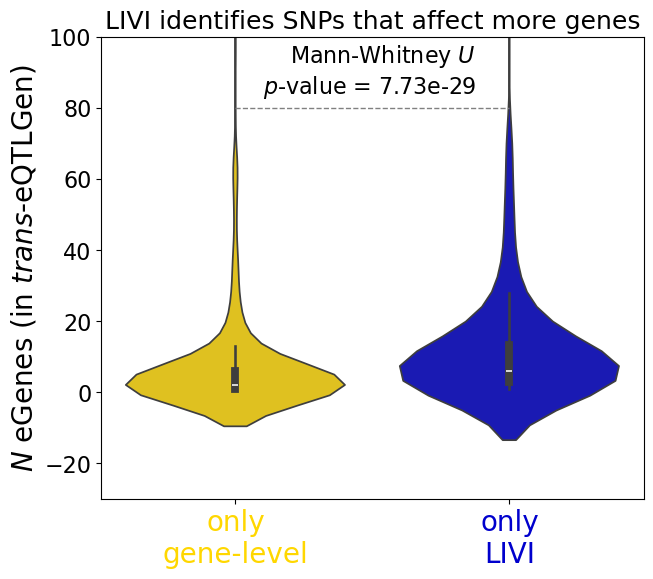

In [28]:
fig, axs = plt.subplots(ncols=1, constrained_layout=False, figsize=(7,6))

sns.violinplot(n_genes_df, y="N_genes", x="only_in", hue="only_in", 
               palette=["gold","mediumblue"], ax=axs, rasterized=True, legend=False)
axs.xaxis.get_ticklabels()[0].set_color("gold") 
axs.xaxis.get_ticklabels()[1].set_color("mediumblue")
axs.set_xticklabels(labels=["only\n"+axs.xaxis.get_ticklabels()[0].get_text(), 
                            "only\n"+axs.xaxis.get_ticklabels()[1].get_text()],
                    fontsize=20)
[t.set_fontsize(16) for t in axs.yaxis.get_ticklabels()] 
axs.set_ylabel("$N$ eGenes (in $trans$-eQTLGen)", fontsize=20)
axs.set_xlabel("")
axs.set_ylim(-30, 100)
y_max = axs.get_ylim()[1]
axs.plot([axs.get_xticks()[0], axs.get_xticks()[1]], 
            [y_max-20, y_max-20], c="grey", linewidth=1, linestyle="--")
# axs.plot([axs.get_xticks()[0], axs.get_xticks()[0]], 
#             [y_max-130, y_max], c="grey", linewidth=1, linestyle="--")
# axs.plot([axs.get_xticks()[1], axs.get_xticks()[1]], 
#             [y_max-10, y_max], c="grey", linewidth=1, linestyle="--")

pval = mannwhitneyu(n_genes_only_livi, n_genes_only_genelevel, alternative="greater")[1]
axs.text(axs.get_xticks()[0]+0.1, y_max-16, f"Mann-Whitney $U$\n$p$-value = {pval:.2e}",
                        fontdict={"color":"black", "fontsize":16, "ma":"right"})
axs.set_title("LIVI identifies SNPs that affect more genes", fontdict={"fontsize":18})

plt.savefig(os.path.join(model_results_dir, "Figures", "Violin-plots_N-eGenes_only-LIVI_vs_only-gene-level_zoom-in.eps"), 
            transparent=True, dpi=400, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", "Violin-plots_N-eGenes_only-LIVI_vs_only-gene-level_zoom-in.png"),
            transparent=True, dpi=400, bbox_inches="tight")